# Vodafone challenge

In [1]:
# Import useful libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Ignore warnings
import warnings
warnings.simplefilter('ignore')

# Import evaluation libraries
from sklearn.metrics import f1_score
from sklearn.model_selection import KFold, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Import model libraries
from xgboost import XGBClassifier


# Random seed for reproducibility
seed = 202
np.random.seed(seed)

In [2]:
# Import the train set and test set
train_data = pd.read_csv("nan_final_train.csv", delimiter=",")
test_data = pd.read_csv("nan_final_test.csv", delimiter=",")

# Drop the ID column
train_data = train_data.drop('ID', axis=1)

# Sort the dataset
train_data = train_data.iloc[np.random.permutation(len(train_data))]
train_data = train_data.reset_index(drop=True)

In [3]:
array = np.asarray(train_data.dropna())

# X,Y are the splits between features and labels used to evaluate SelectKBest
X = array[:,0:train_data.shape[1]-1]
X = np.asarray(X)
Y = array[:,train_data.shape[1]-1]
Y = np.asarray(Y)

# Evaluate the features with a chi2 test by using SelectKBest
# It must be at most max_feature_number - 1
feature_number = 27

chi2_test = SelectKBest(score_func=chi2, k=feature_number)
fit = chi2_test.fit(X,Y)

In [4]:
train_data.columns[chi2_test.get_support(indices=True)]

Index(['DeviceFlag4G', 'DataArpu', 'DataAllowanceContinuous',
       'MonthlyVoiceTrafficCount', 'MonthlySMSTrafficCount',
       'MonthlyDataTraffic', 'CustomerGender', 'CustomerExpatriate', 'ZipCode',
       'ChurnScore', 'AirportConnectionsDuration', 'AirportConnectionsCount',
       'StationConnectionsDuration', 'StationConnectionsCount',
       'ParkingConnectionsDuration', 'ParkingConnectionsCount',
       'File-Transfer', 'Mail', 'Music-Streaming', 'P2P-Applications',
       'Security', 'Streaming-Applications', 'Terminals', 'Web-Applications',
       'CustomerAge', 'Region', 'Province'],
      dtype='object')

In [5]:
def MinMaxScaler_Column(column):
    return (column - column.min())/(column.max()-column.min())

In [6]:
def features_labels_split(data):
    
    features = data[['DeviceFlag4G', 'DataArpu', 'DataAllowanceContinuous',
       'MonthlyVoiceTrafficCount', 'MonthlySMSTrafficCount',
       'MonthlyDataTraffic', 'CustomerGender', 'CustomerExpatriate', 'ZipCode',
       'ChurnScore', 'AirportConnectionsDuration', 'AirportConnectionsCount',
       'StationConnectionsDuration', 'StationConnectionsCount',
       'ParkingConnectionsDuration', 'ParkingConnectionsCount',
       'File-Transfer', 'Mail', 'Music-Streaming', 'P2P-Applications',
       'Security', 'Streaming-Applications', 'Terminals', 'Web-Applications',
       'CustomerAge', 'Region', 'Province']]
    
    data['Region'] = MinMaxScaler_Column(data['Region'])
    data['Province'] = MinMaxScaler_Column(data['Province'])
    data['CustomerAge'] = MinMaxScaler_Column(data['CustomerAge'])
    data['ZipCode'] = MinMaxScaler_Column(data['ZipCode'])
    
    labels = data['Product']
    return features, labels

In [7]:
def train_test_validation_split(features, labels, val_samples, test_samples):

    features = np.asarray(features)
    labels = np.asarray(labels)
    
    X_test = features[0:test_samples]
    y_test = labels[0:test_samples]

    X_val = features[test_samples:test_samples + val_samples]
    y_val = labels[test_samples:test_samples + val_samples]

    X_train = features[test_samples + val_samples:]
    y_train = labels[test_samples + val_samples:]

    return X_train, X_test, X_val, y_train, y_test, y_val

## Computing best features
Before starting the tuning phase, we chose the best number of features for each classifier and we plotted the best (mean) performances that we could observe performing a complete exploration of all the possibilities.

In [8]:
train_feat, train_label = features_labels_split(train_data.dropna())

num_val_samples = 0
num_test_samples = 950
X_train, X_test, X_val, y_train, y_test, y_val = train_test_validation_split(train_feat, train_label, num_val_samples, num_test_samples)

print(train_feat.shape, train_label.shape)
print(X_train.shape, X_test.shape, X_val.shape, y_train.shape, y_test.shape, y_val.shape)

(6160, 27) (6160,)
(5210, 27) (950, 27) (0, 27) (5210,) (950,) (0,)


Model: XGB, Avg_Score: 0.683, Num_Feat: 27


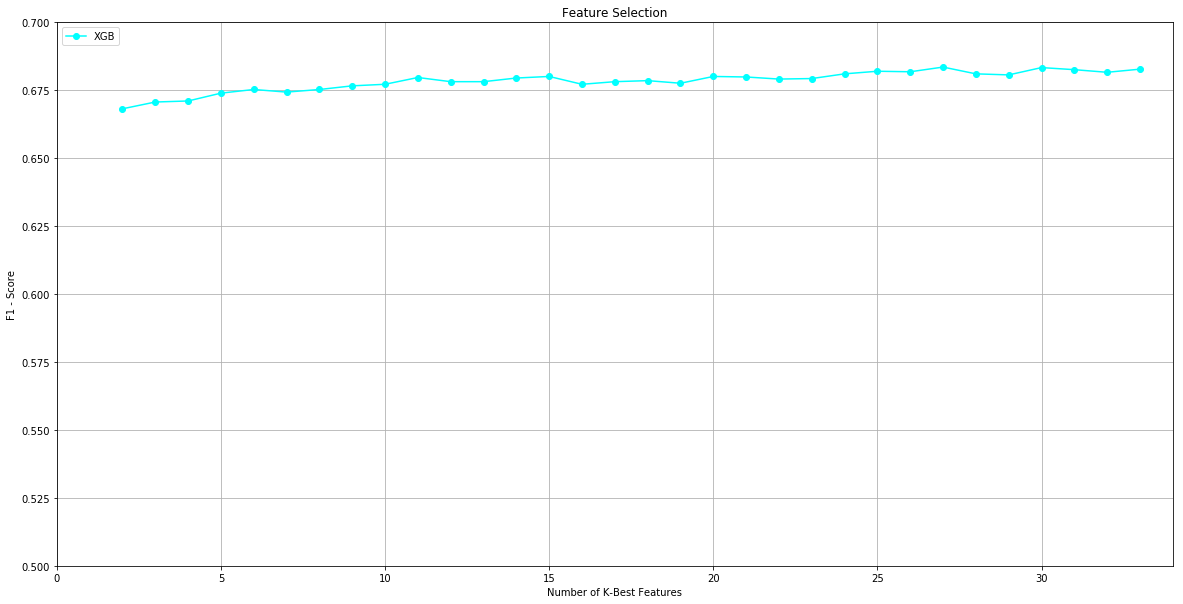

In [24]:
xgb = XGBClassifier(n_jobs=-1, objective='multi:softprob', random_state=seed)

models = []
models.append(('XGB', xgb, 'Cyan'))


feat_range = X_train.shape[1]

n = ['XGB']
n_number = np.arange(2,feat_range,1)
# Transforming the lists into array for plotting
plt.figure(figsize=(20, 10))
plt.title('Feature Selection')
plt.xlabel("Number of K-Best Features")
plt.ylabel("F1 - Score")
plt.grid()

num_feat_arr = []
for name, model, c in models:
    
    scores = [0, 0]
    results = []

    for n in range(2,feat_range):

        selection = SelectKBest(k=n).fit(X_train,y_train)
        X_k = selection.transform(X_train)
        
        score = cross_val_score(estimator = model, X = X_k, y = y_train, cv = 5, scoring='f1_micro')
        f1 = score.mean()
        
        results.append(f1)
        
        std = score.std()
        if scores[0] < f1:
            scores = [f1, n]
  
    plt.plot(n_number, results, 'o-', color=c, label=name)
    
    num_feat_arr.append(scores[1])
    max_avg = np.average(scores)
    
    print("Model: %s, Avg_Score: %.3f, Num_Feat: %d" % (name, scores[0], scores[1]))  


plt.axis([0, feat_range , 0.50, 0.70])
plt.legend(bbox_to_anchor=(0, 1), loc='upper left', ncol=1)
plt.show()

In [9]:
train_feat, train_label = features_labels_split(train_data)

num_val_samples = 0
num_test_samples = 950
X_train, X_test, X_val, y_train, y_test, y_val = train_test_validation_split(train_feat, train_label, num_val_samples, num_test_samples)

print(train_feat.shape, train_label.shape)
print(X_train.shape, X_test.shape, X_val.shape, y_train.shape, y_test.shape, y_val.shape)

(9567, 27) (9567,)
(8617, 27) (950, 27) (0, 27) (8617,) (950,) (0,)


baseXGB: 0.613 (0.007)
XGB: 0.615 (0.008)


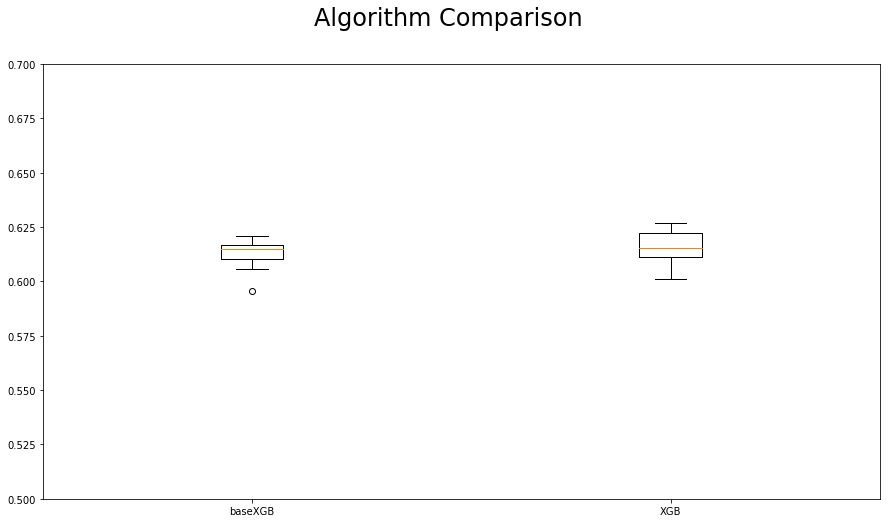

In [12]:
base_xgb = XGBClassifier(n_jobs=-1, objective='multi:softprob', random_state=seed)
xgb = XGBClassifier(learning_rate=0.04, n_estimators=180,
                           max_depth=5, min_child_weight=2, gamma=0.3,
                           subsample = 0.8, colsample_bytree = 0.8,
                           reg_alpha=0.35, reg_lambda=0.25,
                           n_jobs=-1, objective='multi:softprob', random_state=seed)

# Append all the models into an array
models = []
models.append(('baseXGB', base_xgb))
models.append(('XGB', xgb))

# evaluate each model in turn
results = []
names = []
for name, model in models:
    kfold = StratifiedKFold(n_splits=10, random_state=seed)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='f1_micro', n_jobs=-1)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %.3f (%.3f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
    
# boxplot algorithm comparison
fig = plt.figure(figsize=(15, 8))
fig.suptitle('Algorithm Comparison', fontsize=24)
ax = fig.add_subplot(1,1,1)
plt.boxplot(results)
plt.ylim([0.50,0.70])
ax.set_xticklabels(names)
plt.show()

In [13]:
# Test Performance

test_model = XGBClassifier(learning_rate=0.04, n_estimators=180,
                           max_depth=5, min_child_weight=2, gamma=0.3,
                           subsample = 0.8, colsample_bytree = 0.8,
                           reg_alpha=0.35, reg_lambda=0.25,
                           n_jobs=-1, objective='multi:softprob', random_state=seed)
test_model.fit(X_train, y_train)
y_pred = test_model.predict(X_test)
# F1
print("F1 score on unseen data: %.3f" % f1_score(y_test, y_pred, average='micro'))

F1 score on unseen data: 0.628


c:\users\eugen\anaconda3\envs\tensorflow\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [18]:
from sklearn.model_selection import GridSearchCV

classifier = XGBClassifier(
                           max_depth=5, min_child_weight=2, gamma=0.3,
                           subsample = 0.8, colsample_bytree = 0.8,
                           reg_alpha=0.35, reg_lambda=0.25,
                           n_jobs=-1, objective='multi:softprob', random_state=seed)

learning_rate = np.arange(0.01,0.04,0.01)
n_estimators = np.arange(150,400,50)

max_depth = np.arange(2,9,1)
min_child_weight = np.arange(1,6,1)

gamma = (0.25,0.3,0.35)

subsample = (0.75,0.8,0.85)
colsample_bytree = (0.75,0.8,0.85)

reg_alpha = np.arange(0.0,0.6,0.05)
reg_lambda = np.arange(0.0,0.6,0.05)

parameters = [{
    'learning_rate':learning_rate,
    'n_estimators':n_estimators
               }]

grid_search = GridSearchCV(estimator = classifier,
                           param_grid = parameters,
                           scoring='f1_micro',
                           cv = 10,
                           n_jobs = -1)

grid_search = grid_search.fit(X_train, y_train)
best_f1 = grid_search.best_score_
best_parameters = grid_search.best_params_
print(best_f1)
print(best_parameters)

0.6119299059997679
{'learning_rate': 0.03, 'n_estimators': 350}


In [ ]:
0.6115817569919926
{'learning_rate': 0.05, 'n_estimators': 150}
0.6136706510386445
{'max_depth': 5, 'min_child_weight': 2}
0.6140188000464198
{'gamma': 0.3, 'colsample_bytree': 0.8, 'subsample': 0.8}
0.6151792967390043
{'reg_alpha': 0.35000000000000003, 'reg_lambda': 0.25}

In [14]:
X_pred = test_data[train_data.columns[chi2_test.get_support(indices=True)]]

In [15]:
classifier = XGBClassifier(learning_rate=0.04, n_estimators=180,
                           max_depth=5, min_child_weight=2, gamma=0.3,
                           subsample = 0.8, colsample_bytree = 0.8,
                           reg_alpha=0.35, reg_lambda=0.25,
                           n_jobs=-1, objective='multi:softprob', random_state=seed)
classifier.fit(train_feat, train_label)
y_pred = classifier.predict(X_pred)

c:\users\eugen\anaconda3\envs\tensorflow\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [16]:
submit = test_data['ID']
submit = pd.DataFrame({'ID': submit})

pred = y_pred
pred = pd.DataFrame({'Product': y_pred})

product = []
product = pred.Product
product.replace({ 
    int(0) : 'Non-Customer', 
    int(1) : 'V-Auto', 
    int(2) : 'V-Bag', 
    int(3) : 'V-Pet'},
    inplace=True)

submit = submit.join(product)
submit.to_csv('Main_prediction.csv', index = False, encoding='utf-8')